Importamos xgboost ya que no es parte de Anaconda. La versión que hemos usado es la 2.1.3

In [12]:
pip install xgboost==2.1.3

Note: you may need to restart the kernel to use updated packages.


Dado que estamos usando xgboost, la versión compatible que mejor nos ha funcionado ha sido la 1.4.0 de scikit-learn (sklearn)

In [13]:
pip install scikit-learn==1.4.0

Note: you may need to restart the kernel to use updated packages.


In [14]:
#Comprobar que se tienen las versiones nombradas anteriormente
import sklearn
import xgboost
print(sklearn.__version__)
print(xgboost.__version__)

1.4.0
2.1.3


### Introducción

Dado que de unos valores x queremos estimar un valor continuo y usaremos un modelo de regresión linear.

### 1er Paso:

Comenzamos la práctica importando los datos de public_test.csv y public_train.csv 

In [15]:
import pandas as pd

# Dataframe
test_data = pd.read_csv("public_test.csv")
train_data = pd.read_csv("public_train.csv")

# Visualizamos de forma general el estado de los datos
test_data.head()
train_data.head()

,ccs,adduct,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,desc_8,...,fgp_611,fgp_612,fgp_613,fgp_614,fgp_615,fgp_616,fgp_617,fgp_618,fgp_619,fgp_620
0,155.71001,Monomer_[M+H],-5.27492,420.85751,0.79886,60.68518,0.22702,54.36304,55.73885,8.28095,...,0,0,1,0,1,1,1,0,1,0
1,179.56000,Monomer_[M-H],-2.00000,1171.97156,1.13333,121.96276,0.15520,100.45390,97.68512,11.36667,...,1,0,0,1,0,1,0,1,1,0
2,180.00000,Monomer_[M+Na],-0.70060,1447.22644,1.30616,141.10509,0.13916,110.47855,108.96603,12.96667,...,0,1,1,0,1,0,0,0,0,1
3,155.53999,Monomer_[M+Na],0.00000,479.80600,0.92774,74.90678,0.21166,65.64590,66.68343,6.83333,...,1,0,1,1,1,0,1,1,0,0
4,173.50000,Monomer_[M+H],-1.63669,978.85028,1.24843,112.27611,0.15789,87.88085,89.68015,10.73333,...,0,1,0,1,0,0,1,0,1,0


### 2ndo Paso:

Primera parte de preprocesamiento: 

 + Proceso de identificar las columnas 
 + Separar las características y el objetivo (a predecir)

In [16]:
# Identificar columnas
TARGET = "ccs"
CATEGORICAL_FEATURES = ["adduct"]
NUMERIC_FEATURES = [col for col in train_data.columns if col.startswith("desc_")]
BINARY_FEATURES = [col for col in train_data.columns if col.startswith("fgp_")]

# Separar características y objetivo
x = train_data.drop(columns=[TARGET]) # Características
y = train_data[TARGET] # Valor a estimar


### Modelo + prepocesado 2.0

En este apartado creamos una función, en la cual se continua con el prepocesamiento de los datos de public_train.csv e implementa XGBoost a la ecuación. XGBoost tiene un método de regresión que es el que utilizaremos tras pasarle unos parametros. La idea es que una vez se han definido los parametros y la primera parte de preprocesamiento, se llame a la función y esta devuelva el modelo. 

In [17]:
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


def create_preproc_and_model(numeric_features , categorical_features, binary_features ,params, x_train, y_train, x_test, y_test):
    scaler = StandardScaler()
    numeric_imputer = SimpleImputer(strategy="median")
    categorical_imputer = SimpleImputer(strategy="most_frequent")
    oh_encoder = OneHotEncoder(handle_unknown='ignore')

    numeric_transformer = Pipeline(steps=[
        ("imputer", numeric_imputer),
        ("scaler", scaler)
    ])
    categorical_transformer = Pipeline(steps=[
        ("imputer", categorical_imputer),
        ("encoder", oh_encoder)
    ])

    transformer = ColumnTransformer(
        transformers=[
            ('numeric_imp', numeric_transformer, NUMERIC_FEATURES),
            ('categorial_imp', categorical_transformer, CATEGORICAL_FEATURES),
            ('binary', 'passthrough', BINARY_FEATURES) 
        ],
        remainder="drop" # Fuera lo que no se pueda transformar
    )
    # Convertir los datos a DMatrix
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)

    # Transferir a la GPU
    dtrain.set_device('cuda:0')
    dtest.set_device('cuda:0')
    # Crear modelo XGBoost con los parámetros
    model = xgb.XGBRegressor(**params)
    
    return Pipeline(steps=[
        ("preprocessor", transformer),
        ("model", model)
    ])


### 3er Paso:

En este apartado se realiza el entrenamiento del modelo con test_size de 20% que es un valor equilibrado y random_state=42 para que los valores de las pruebas no varien tanto. Por otro lado, en este apartado pasamos los parametros necesarios a la función anterior y finalmente comenzamos la fase de comprobación metrica funcional. Hemos evaluado diferentes métricas, pero como la que se nos va a evaluar es Median Absolute Error, a esta le hemos añadido cross_val_score para sacar una media de los resultados y poder analizar un resultado más estable. 

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, make_scorer
import numpy as np

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size=0.2, random_state=42)

# Hay que ajustar el modelo y seleccionar el que mejor rendimiento tiene.

params = {
        "objective": "reg:squarederror",  # Para regresión
        "booster": "gbtree",           # Usa modelo lineal
        "alpha": 0.15,                    # Regularización L1 (Lasso)
        "lambda": 1,                   # Regularización L2 (Ridge)
        "n_estimators": 700,             # Número de árboles que se entrenan
        "learning_rate": 0.02,           # Conservador vs rápido
        "max_depth": 7,
        "n_jobs": -1,     # SI TIENE COLUMNAS CATEGóRICAS
        "random_state": 42,
        "tree_method": "hist"
    }
pipeline = create_preproc_and_model(numeric_features=NUMERIC_FEATURES, categorical_features=CATEGORICAL_FEATURES, binary_features=BINARY_FEATURES,params=params, x_train=x_train , x_test=x_test , y_train=y_train , y_test=y_test)

pipeline.fit(x_train , y_train)

predicciones = pipeline.predict(x_test)

mse = mean_squared_error(y_test, predicciones)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

scorer = make_scorer(median_absolute_error, greater_is_better=False)
scores = cross_val_score(pipeline, x, y, cv=5, scoring=scorer, n_jobs=-1)
medae_scores = -scores  # Convert negative scores to positive
mean_medae = np.mean(medae_scores)
print(f"Mean Median Absolute Error across CV: {mean_medae}")


#def median_squared_error(y_true, y_pred):
#    return np.median((y_true - y_pred) ** 2)

#median_squared_error_scorer = make_scorer(median_squared_error, greater_is_better=False)
#scores = cross_val_score(pipeline, x, y, cv=5, scoring=median_squared_error_scorer, n_jobs=-1)
#cv_median = -scores.mean()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:adduct: object

### 4rto Paso:

En este último apartado, se predicen los valores de public_test.csv, estos se visualizan y se guardan en test_preds.csv

In [16]:
import numpy as np

predicciones_test = pipeline.predict(test_data)

print("Predicciones para test_data:")
print(predicciones_test)

np.savetxt("test_preds.csv", predicciones_test, delimiter=",")

print("Predicciones guardadas en: " , "test_preds.csv")

Predicciones para test_data:
[175.91231 256.70615 225.64664 ... 210.81573 172.65707 285.58334]
Predicciones guardadas en:  test_preds.csv


### Comprobador de overfitting y underfitting


Resultados en conjunto de entrenamiento:
MedAE: 1.2783892822265557
R²: 0.9984068025852978

Resultados en conjunto de prueba:
MedAE: 2.6303259277343756
R²: 0.9863176887998054

Resultados de validación cruzada:
MedAE promedio: 2.7153664143880243


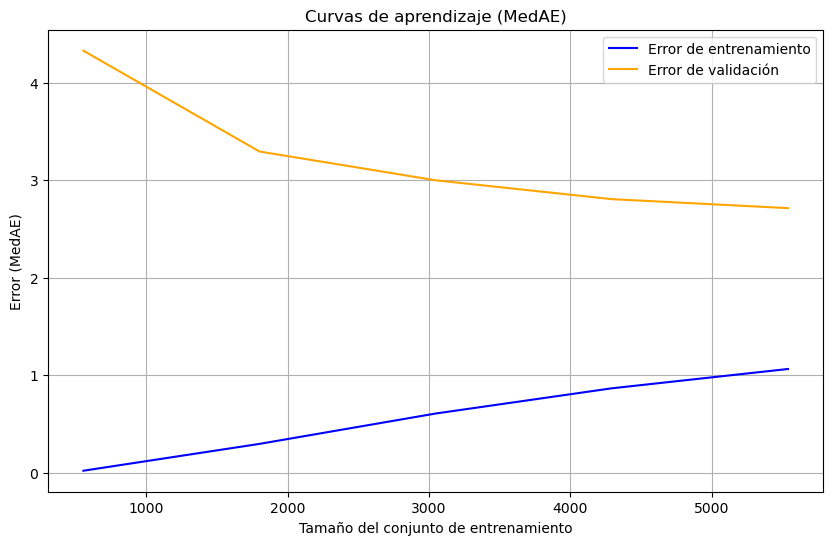

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# División de datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Parámetros del modelo
params = {
        "objective": "reg:squarederror",  # Para regresión
        "booster": "gbtree",           # Usa modelo lineal
        "alpha": 0.15,                    # Regularización L1 (Lasso)
        "lambda": 1,                   # Regularización L2 (Ridge)
        "n_estimators": 700,             # Número de árboles que se entrenan
        "learning_rate": 0.02,           # Conservador vs rápido
        "max_depth": 7,
        "n_jobs": -1,
        #"enable_categorical": True,      # SI TIENE COLUMNAS CATEGóRICAS
        "random_state": 42
        #"tree_method": "hist" 
    }

# Crear pipeline
pipeline = create_preproc_and_model(NUMERIC_FEATURES, CATEGORICAL_FEATURES, BINARY_FEATURES, params=params)

# Entrenamiento
pipeline.fit(x_train, y_train)

# Predicciones en entrenamiento y prueba
pred_train = pipeline.predict(x_train)
pred_test = pipeline.predict(x_test)

# Métricas de entrenamiento
medae_train = median_absolute_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)

# Métricas de prueba
medae_test = median_absolute_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)

# Resultados
print("\nResultados en conjunto de entrenamiento:")
print("MedAE:", medae_train)
print("R²:", r2_train)

print("\nResultados en conjunto de prueba:")
print("MedAE:", medae_test)
print("R²:", r2_test)

# Validación cruzada
print("\nResultados de validación cruzada:")
scores = cross_val_score(pipeline, x, y, cv=3, scoring='neg_median_absolute_error')
cv_medae = -scores.mean()
print("MedAE promedio:", cv_medae)

# Curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, x, y, cv=3, scoring='neg_median_absolute_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Error de entrenamiento", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Error de validación", color="orange")
plt.title("Curvas de aprendizaje (MedAE)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error (MedAE)")
plt.legend()
plt.grid()
plt.show()

# Conclusión: 
 
+ Limitaciones identificadas: 

   + Limitación de las características: Aunque el dataset incluye descriptores moleculares y fingerprints esto parece insuficiente para capturar completamente las propiedades complejas de las moléculas. Esto podría haber afectado la capacidad del modelo para conseguir hacer predicciones precisas en los casos más atípicos. 

   + Limitación de hardware: No disponíamos de TPU, y nuestras GPUs no eran de última generación y algunos no disponían de GPUs Nvidia.  


+ Posibles mejoras: 

   + Una opción barajamos fue la de utilizar SMOTE con el fin de poder aumentar el volumen de datos que teníamos, pero terminó herramienta para problemas de clasificación, y a pesar de investigar sobre un tal SMOTER (R de regresión), no terminamos herramientas de este este estilo. 

   + Creemos que el preprocesamiento podría mejorarse con diferentes técnicas preprocesamiento de datos, como KNNImputer, que probamos, pero debido a que no nos dieron los resultados esperados, decidimos no indagar más 

   + No probamos a cambiar valore como el test_size, lo cual podría hacer que el modelo aprendiese mejor. 

   + Buscar alternativas que nos permitiesen a todos los colaboradores, utilizar sus GPUs (no al clasismo). 

   + Una GPU NVIDIA Quadro A4000, para la proxima si se nos da un presupuesto de unos 10000$ sería más rápido el proceso :) 

 
+ Lecciones aprendidas: 

   + En esta práctica hemos utilizado el ensamble XGBoost, el cual ha tenido cosas buenas y cosas malas.  

   + Las buenas: es que muchas cosas como regular el grado del polinomio (descenso de gradiente) las hace de forma automática, el introducir parámetros y poder realizar comparaciones de estos, incluso XGBoost tiene la opción de aumentar o disminuir L1 y L2. También nos gustó la facilidad para adaptarlo a un modelo de regresión linear. 

   + Las malas: Para usar parámetros como gpu_hist, requieres de gráficas de Nvidia (y algunos miembros no la tenían disponible), por lo que hemos tenido que utilizar Google Colab como herramienta clave. Incompatibilidades con otras bibliotecas como sklearn que supusieron un problema al principio. 

   + Exploración de alternativas: Aunque XGBoost proporcionara resultados buenos, nos hubiera quedado por probar técnicas complementarias para contrastar los resultados e identificar otro modelo alternativo. 

   + Dentro de XGBoost también tuvimos que escoger, entre gblinear, gbtree y dart (una de la que más tiempo invertimos en perfeccionar), como booster. Lo que nos hizo aprender sobre nuevos parámetros y técnicas que utilizan cada uno de ellos. Nos decidimos por gbtree dado que dart tardaba mucho tiempo y los resultados eran similares, a pesar de que dart implementase herramientas para recortar tiempo de cómputo. 

 

# Pruebas de parametros, SUCIO 

Estos son algunos de los intentos de programa que fuimos probando, desde gblinear a dart. Utilizamos técnicas para probar parámetros como RandomizedSearchCV junto con uniform y radiant (MUCHO tiempo de cómputo). Probamos imputers como KNNImputer, pero que descartamos debido al tiempo de computo y baja (o nula) mejora que nos traía. También calculamos métricas como el Median Square Error, pero que terminamos descartando.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import median_absolute_error, mean_squared_error, make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy.stats import uniform, randint

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Cargar el dataset
train_data = pd.read_csv("public_train.csv")

# Identificar columnas
TARGET = "ccs"
CATEGORICAL_FEATURES = ["adduct"]
NUMERIC_FEATURES = [col for col in train_data.columns if col.startswith("desc_")]
BINARY_FEATURES = [col for col in train_data.columns if col.startswith("fgp_")]

# Separar características y objetivo
X = train_data.drop(columns=[TARGET])
y = train_data[TARGET]

# Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder="passthrough"
)

# Modelo base
base_params = {
    "objective": "reg:squarederror",
    "booster": "dart",
    "tree_method": "hist",
    "random_state": 42,
}
model = XGBRegressor(**base_params)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", SelectFromModel(XGBRegressor(**base_params), prefit=False)),
    ("model", model)
])

# Definir espacio de hiperparámetros para búsqueda aleatoria
param_distributions = {
    "model__learning_rate": [0.01],
    "model__n_estimators": [300],
    "model__max_depth": [8],
    "model__subsample": [0.6],
    "model__colsample_bytree": [0.5],
    "model__alpha": [0.08],
    "model__lambda": [0.5],
    "model__rate_drop": [0.15],
    "model__skip_drop": [0.2 ,0.3],
}

# Definir Median Squared Error como scorer
def median_squared_error(y_true, y_pred):
    return np.median((y_true - y_pred) ** 2)

median_squared_error_scorer = make_scorer(median_squared_error, greater_is_better=False)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# División del dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar RandomizedSearchCV
random_search.fit(X_train, y_train)

# Evaluar los mejores parámetros
print("Mejores parámetros:", random_search.best_params_)
print("Mejor puntuación (neg MedSE):", random_search.best_score_)

### Adaptado para entrenamiento con GPU NVIDIA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import median_absolute_error, mean_squared_error, make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Cargar el dataset
train_data = pd.read_csv("public_train.csv")

# Identificar columnas
TARGET = "ccs"
CATEGORICAL_FEATURES = ["adduct"]
NUMERIC_FEATURES = [col for col in train_data.columns if col.startswith("desc_")]
BINARY_FEATURES = [col for col in train_data.columns if col.startswith("fgp_")]

# Separar características y objetivo
X = train_data.drop(columns=[TARGET])
y = train_data[TARGET]

# Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder="passthrough"
)

# Parámetros del modelo
params = {
    "objective": "reg:squarederror",  # Para regresión
    "booster": "gbtree",           # Usa modelo lineal
    "alpha": 0.15,                    # Regularización L1 (Lasso)
    "lambda": 1,                   # Regularización L2 (Ridge)
    #n_estimators": 700,             # Número de árboles que se entrenan
    "learning_rate": 0.02,           # Conservador vs rápido
    "max_depth": 7,
    "n_jobs": -1,      # Usar GPU con histograma acelerado
    "random_state": 42,
    "tree_method": "hist",
    "device": "cuda"

}

# Dividir el dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesar las características
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

# Convertir a DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train_transformed, label=y_train)
dval = xgb.DMatrix(X_val_transformed, label=y_val)

# Entrenar el modelo
model = xgb.train(params, dtrain, num_boost_round=700)

# Realizar predicciones en el conjunto de validación
y_pred = model.predict(dval)
medae = median_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"Median Absolute Error (MedAE): {medae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Validación cruzada con MedSE
def median_squared_error(y_true, y_pred):
    return np.median((y_true - y_pred) ** 2)

# Cargar el conjunto de prueba
test_data = pd.read_csv("public_test.csv")

# Preprocesar el conjunto de prueba
test_transformed = preprocessor.transform(test_data)

# Convertir a DMatrix
dtest = xgb.DMatrix(test_transformed)

# Realizar predicciones para el conjunto de prueba
test_predictions = model.predict(dtest)

# Guardar las predicciones en un archivo CSV
output_file = "test_predictionsMean.csv"
pd.DataFrame(test_predictions).to_csv(output_file, index=False, header=False)
print(f"Predicciones guardadas en {output_file}")


Median Absolute Error (MedAE): 2.647586481933587
Mean Squared Error (MSE): 45.13856097155186
Root Mean Squared Error (RMSE): 6.718523719653884
Predicciones guardadas en test_predictionsMean.csv
